# NB8 - Reproducing Cambridge Analytica's work

Cambridge Analytica was a London-based company founded in 2013, specializing in Big Data analysis and the application of psychological profiling. One of their most well-known methods was based on the Big Five personality traits, also known as the OCEAN model. The OCEAN model suggests that human personality can be described using five broad dimensions:

- **Extraversion** : Reflects a person's tendency to seek stimulation in the company of others. High scorers are outgoing, talkative, and energetic, while low scorers tend to be reserved and prefer solitary activities.
- **Neuroticism** : Measures emotional stability and the tendency to experience negative emotions like anxiety, sadness, or irritability. Higher scores indicate greater emotional sensitivity, while lower scores suggest calm and resilience under stress.
- **Agreeableness** : Captures the extent to which a person is cooperative, empathetic, and willing to help others. High scorers are compassionate and trusting, while low scorers may be more competitive or skeptical of others' motives.
- **Conscientiousness** : Describes a person’s level of self-discipline, organization, and goal-directed behavior. High scorers are diligent, detail-oriented, and reliable, while low scorers may be more spontaneous or less focused on long-term goals.
- **Openness** : Reflects a person's openness to new experiences, creativity, and curiosity. High scorers are imaginative and adventurous, while low scorers prefer routine and are more traditional in their views.

In addition to psychological profiling, Cambridge Analytica’s services were employed by various political campaigns globally, most notably by candidates such as Ben Carson, Ted Cruz, and Donald Trump during the 2016 U.S. presidential election. The company faced significant controversy for allegedly harvesting personal data from millions of Facebook users. They used a quiz, which users voluntarily completed, to gather information about individuals' personalities. This data, combined with users' social connections, posts, and likes, enabled Cambridge Analytica to target potential voters for political campaigns, influencing their strategies.

In this notebook, we aim to replicate a simplified version of this work, but without the ethical concerns. Instead of illicitly collecting data, we use publicly available responses to the OCEAN personality test. As outlined in the supplementary Python files, we generated a target column to simulate identifying individuals who might be inclined to vote for a particular political candidate. The goal is to explore how personality traits could potentially correlate with political preferences in a machine learning context.

This is not 100% accurate, but the main ideas are the ones that were used by Cambridge Analytica. The steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.


In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

df = pd.read_csv("Analytica.csv")

OCEAN = {
    "EXT": "Extraversion",
    "EST": "Neuroticism",
    "AGR": "Agreeableness",
    "CSN": "Conscientiousness",
    "OPN": "Openness",
}
dimensions = list(OCEAN.keys())

df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,EXT_time,EST,EST_time,AGR,AGR_time,CSN,CSN_time,OPN,OPN_time,target
0,3.0,2.0,2.0,4.0,4.0,4.0,5.0,3.0,1.0,3.0,...,72.625,0.44,46.155,0.24,82.665,0.10,62.022,0.10,40.415,NaN
1,3.0,4.0,1.0,4.0,3.0,2.0,2.0,4.0,3.0,5.0,...,45.790,0.42,36.420,-0.14,86.422,0.10,56.401,0.26,38.205,0.0
2,3.0,3.0,4.0,4.0,5.0,3.0,3.0,5.0,2.0,2.0,...,64.250,0.42,50.268,0.50,58.487,0.18,44.737,0.34,51.454,NaN
3,1.0,5.0,1.0,5.0,2.0,4.0,1.0,5.0,3.0,5.0,...,50.384,0.64,59.489,0.22,59.080,0.18,66.815,0.32,58.911,NaN
4,1.0,4.0,3.0,5.0,1.0,2.0,2.0,4.0,2.0,4.0,...,59.927,0.46,39.848,0.40,97.554,0.24,45.858,0.42,48.390,0.0


## Analysis

We have 10 question per dimension, and the time in second taken to respond to each question. We also have the overall score for each dimension and the time take to answer all of the questions.
Let's first have a look at the distribution for the overall scores.

**Task** : Using the code in the following cell, analyse its output.


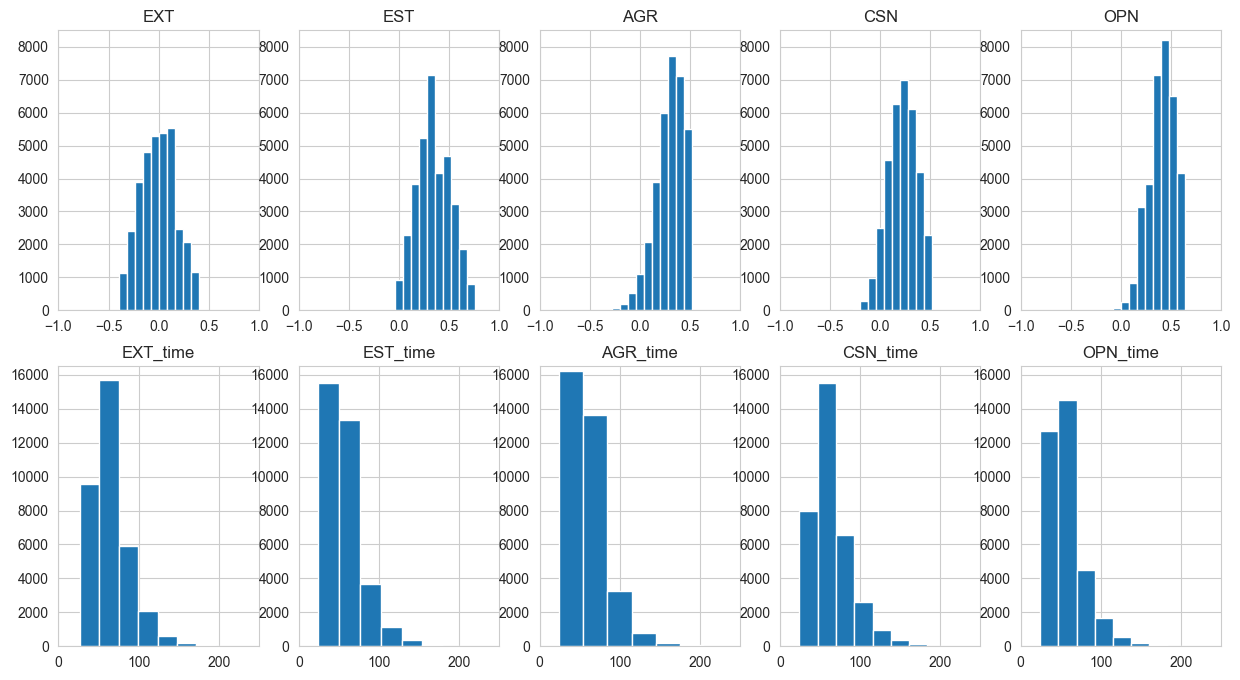

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style="whitegrid")

plt.figure(figsize=(15, 8))

for index in range(1, 6):
    plt.subplot(2, 5, index)
    column = dimensions[index - 1]
    plt.hist(df[column])
    plt.xlim(-1, 1)
    plt.ylim(0, 8500)
    plt.title(column)

    plt.subplot(2, 5, index + 5)
    column = column + "_time"
    plt.hist(df[column])
    plt.xlim(0, 250)
    plt.ylim(0, 16500)
    plt.title(column)

plt.show()

Before diving in the modelisation, one need to check for missing values.

**Task** : Using the [`isna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html) method along with the [`sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html#pandas.DataFrame.sum) method, look for missing values in the dataset. As there is 100+ columns, only display the ones with missing values.


In [3]:
df.isna().sum()

EXT1            0
EXT2            0
EXT3            0
EXT4            0
EXT5            0
            ...  
CSN             0
CSN_time        0
OPN             0
OPN_time        0
target      29067
Length: 112, dtype: int64

As expected, we have only 15% _target_ variable available. Our goal is to regroup people that _looks_ the same and then project the target into the groups.

## Modelisation

But first, as we saw, we need to scale all the distributions.

**Task** : Extract from the dataframe all the columns except the target one, then use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class. Keep the target in a vector named _y_ for convenience.


In [4]:
X = df.drop(columns=["target"])
y = df["target"]

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original data - Mean: {X.mean(axis=0)[:3]}, Std: {X.std(axis=0)[:3]}")
print(
    f"Scaled data - Mean: {X_scaled.mean(axis=0)[:3]}, Std: {X_scaled.std(axis=0)[:3]}"
)

Original data - Mean: EXT1    2.609080
EXT2    2.862044
EXT3    3.342125
dtype: float64, Std: EXT1    1.229102
EXT2    1.319434
EXT3    1.196898
dtype: float64
Scaled data - Mean: [ 1.70548559e-16 -1.24791629e-16 -1.93427025e-16], Std: [1. 1. 1.]


As we have 112 columns, we should first reduce the dimension of our dataset.

### PCA

We will use [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (Principal Component Analysis) to do this.

**Task** : Reduce the dimension to 20 variables using the `fit` then `transform` method.


In [6]:
from sklearn.decomposition import PCA

# Fit PCA with all components
pca_full = PCA(n_components=20)
X_pca = pca_full.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape}")
print(f"PCA transformed dimensions: {X_pca.shape}")
print(f"\nNumber of components: {pca_full.n_components_}")

Original dimensions: (34163, 111)
PCA transformed dimensions: (34163, 20)

Number of components: 20


Can we measure how _good_ our PCA is ? The theory tells that the sum of all the eigenvalue of dimension is equal to the overall variance of the dataset. Here we kept only 20 over 112, so how much of variance did we _explained_ ?

**Task** : Using the `explained_variance_ratio` attribute in the PCA model, answer the question.


In [ ]:
# Explained variance
explained_var = pca_full.explained_variance_
explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

print("Explained variance by component:")
for i in range(len(explained_var)):
    print(
        f"PC{i+1}: {explained_var[i]:.4f} ({explained_var_ratio[i]*100:.2f}%, cumulative: {cumulative_var_ratio[i]*100:.2f}%)"
    )

Explained variance by component:
PC1: 10.8326 (9.76%, cumulative: 9.76%)
PC2: 9.4439 (8.51%, cumulative: 18.27%)
PC3: 5.7758 (5.20%, cumulative: 23.47%)
PC4: 4.6660 (4.20%, cumulative: 27.67%)
PC5: 4.3457 (3.91%, cumulative: 31.59%)
PC6: 3.3940 (3.06%, cumulative: 34.65%)
PC7: 1.6101 (1.45%, cumulative: 36.10%)
PC8: 1.4787 (1.33%, cumulative: 37.43%)
PC9: 1.4073 (1.27%, cumulative: 38.70%)
PC10: 1.3293 (1.20%, cumulative: 39.89%)
PC11: 1.2838 (1.16%, cumulative: 41.05%)
PC12: 1.2621 (1.14%, cumulative: 42.19%)
PC13: 1.2374 (1.11%, cumulative: 43.30%)
PC14: 1.1241 (1.01%, cumulative: 44.31%)
PC15: 1.1008 (0.99%, cumulative: 45.31%)
PC16: 1.0517 (0.95%, cumulative: 46.25%)
PC17: 1.0217 (0.92%, cumulative: 47.17%)
PC18: 1.0092 (0.91%, cumulative: 48.08%)
PC19: 0.9976 (0.90%, cumulative: 48.98%)
PC20: 0.9712 (0.87%, cumulative: 49.86%)


So we kept ~50% of the variance using only 18% dimensions (20 / 111) which is good but not great. We will try to improve this part later.

### KMeans

As we have a smaller dataset in terms of dimension, the KMeans algorithm can be used.

**Task** : Using the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, get a vector named _cluster_ which is the result of the `predict` method of [`KMeans`] class. We will build 5 clusters.


In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

In [18]:
print(f"\nClustering complete ")
print(f"\nCluster distribution:")
for i in range(20):
    count = np.sum(cluster_labels == i)
    print(f"  Cluster {i}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")


Clustering complete 

Cluster distribution:
  Cluster 0: 1179 samples (3.5%)
  Cluster 1: 2243 samples (6.6%)
  Cluster 2: 1872 samples (5.5%)
  Cluster 3: 1773 samples (5.2%)
  Cluster 4: 1343 samples (3.9%)
  Cluster 5: 1897 samples (5.6%)
  Cluster 6: 680 samples (2.0%)
  Cluster 7: 1765 samples (5.2%)
  Cluster 8: 2108 samples (6.2%)
  Cluster 9: 2178 samples (6.4%)
  Cluster 10: 2171 samples (6.4%)
  Cluster 11: 1240 samples (3.6%)
  Cluster 12: 2351 samples (6.9%)
  Cluster 13: 1457 samples (4.3%)
  Cluster 14: 1571 samples (4.6%)
  Cluster 15: 1402 samples (4.1%)
  Cluster 16: 2109 samples (6.2%)
  Cluster 17: 2076 samples (6.1%)
  Cluster 18: 1228 samples (3.6%)
  Cluster 19: 1520 samples (4.4%)


And... is it good ? We do not have any ground truth this time, but we can look at the [`silhouette score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) function to have an idea of how well cluster are shaped.

**Task** : Compute and analyse the silhouette score of our model.


In [19]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"\nSilhouette Score for k=20: {silhouette_avg:.4f}")


Silhouette Score for k=20: 0.0478


It is not great... We will improve this value but we need to _understand_ what the clusters are about.

### Analysis

**Task** : Extract for the original dataframe the 5 overall score and the target in a dataframe, then add the predicted cluster.


In [23]:
new_df = df.copy()
featured_df = new_df[OCEAN.keys()]
featured_df["cluster"] = cluster_labels
featured_df["target"] = new_df["target"]

featured_df.head()

/var/folders/nd/jw9h_5215q3cx8t5kjj7fyg40000gn/T/ipykernel_24499/2270231881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_df["cluster"] = cluster_labels
/var/folders/nd/jw9h_5215q3cx8t5kjj7fyg40000gn/T/ipykernel_24499/2270231881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_df["target"] = new_df["target"]


,EXT,EST,AGR,CSN,OPN,cluster,target
0,-0.02,0.44,0.24,0.10,0.10,3,NaN
1,-0.14,0.42,-0.14,0.10,0.26,4,0.0
2,0.00,0.42,0.50,0.18,0.34,9,NaN
3,-0.32,0.64,0.22,0.18,0.32,4,NaN
4,-0.20,0.46,0.40,0.24,0.42,8,0.0


We are interested in the _target_ column, which is binary. Therefore we would like to know the distribution in each cluster for the target.

**Task** : Use the [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method along with the [`agg`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.agg.html) method to get both the number in each cluster (using _count_) and the distribution (using _mean_). Then analyse.


In [32]:
grouped = featured_df.groupby(["cluster"]).mean()
grouped_counted = featured_df.groupby(["cluster"]).count()
grouped
grouped_counted

,EXT,EST,AGR,CSN,OPN,target
cluster,,,,,,
0,1179,1179,1179,1179,1179,171
1,2243,2243,2243,2243,2243,378
2,1872,1872,1872,1872,1872,294
3,1773,1773,1773,1773,1773,269
4,1343,1343,1343,1343,1343,193
5,1897,1897,1897,1897,1897,280
6,680,680,680,680,680,107
7,1765,1765,1765,1765,1765,264
8,2108,2108,2108,2108,2108,321


In [ ]:
grouped = featured_df.groupby("cluster").agg({"target": ["count", "mean"]})
grouped

target          
         count      mean
cluster                 
0          171  0.385965
1          378  0.703704
2          294  0.802721
3          269  0.620818
4          193  0.202073
5          280  0.296429
6          107  0.485981
7          264  0.439394
8          321  0.358255
9          315  0.812698
10         328  0.198171
11         198  0.651515
12         321  0.417445
13         201  0.681592
14         238  0.184874
15         210  0.290476
16         295  0.033898
17         293  0.815700
18         181  0.662983
19         239  0.326360

To better grasp the distribution of the each cluster according to the overall score, we will use the [`barplot`](https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot) function of seaborn.


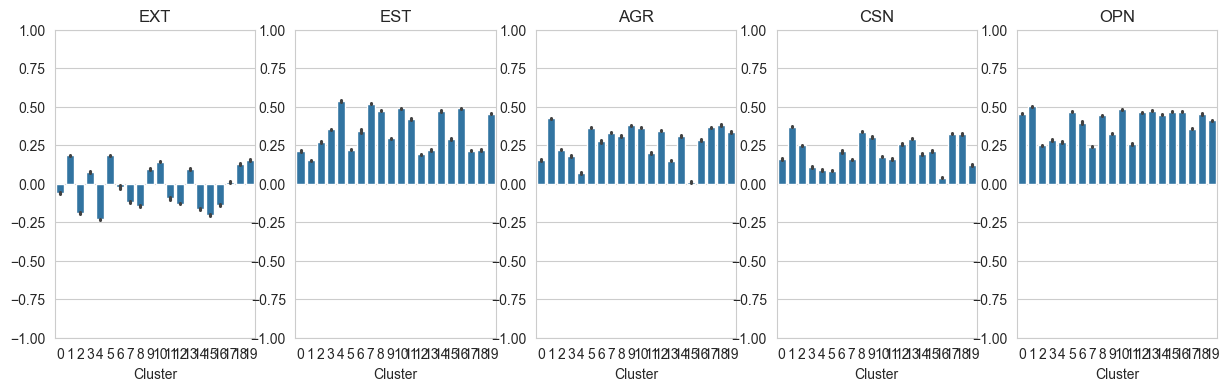

In [30]:
plt.figure(figsize=(15, 4))

for index, dimension in enumerate(dimensions):
    plt.subplot(1, 5, index + 1)
    sns.barplot(data=featured_df, x=cluster_labels, y=dimension, estimator="mean")
    plt.xlabel("Cluster")
    plt.ylabel("")
    plt.ylim(-1, 1)
    plt.title(dimension)
plt.show()

We need to do a bit better.

## Time to improve

We have three areas to improve :

1. Feature selections : is it necessary to keep all the variables ?
2. PCA components : what is the optimal value for the number of components to keep ?
3. KMeans cluster : what is the optimal value for the number of clusters ?

We will focus only on the last two questions here, and left the first to the reader. Let's start with the PCA, as it will impact the clustering.

### PCA Components

We have a measure of explained variance, we shall use it. Before we need to _refresh_ our dataset so that we do not keep previous transformations.


In [33]:
df = pd.read_csv("Analytica.csv")
X = df.drop(columns=["target"])
y = df["target"]
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Task** : Compute the explained variance for different values of components to keep.


In [41]:
for k in [2, 3, 4, 5, 10, 15, 20, 25]:
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")

Silhouette Score for k=2: 0.3820
Silhouette Score for k=3: 0.2721
Silhouette Score for k=4: 0.1951
Silhouette Score for k=5: 0.1459
Silhouette Score for k=10: 0.0957
Silhouette Score for k=15: 0.0619
Silhouette Score for k=20: 0.0478
Silhouette Score for k=25: 0.0344


In [46]:
n_components_range = range(1, X.shape[1] + 1)
explained_variance_ratios = []

for n in n_components_range:
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_variance_ratios.append(sum(pca.explained_variance_ratio_))

# Store results for plotting
pca_results = pd.DataFrame(
    {
        "n_components": list(n_components_range),
        "cumulative_variance": explained_variance_ratios,
    }
)

print(pca_results.head(20))

    n_components  cumulative_variance
0              1             0.097588
1              2             0.182665
2              3             0.234698
3              4             0.276733
4              5             0.315882
5              6             0.346458
6              7             0.360963
7              8             0.374284
8              9             0.386962
9             10             0.398938
10            11             0.410503
11            12             0.421873
12            13             0.433020
13            14             0.443147
14            15             0.453063
15            16             0.462537
16            17             0.471741
17            18             0.480833
18            19             0.489821
19            20             0.498569


**Task** : Display the result of the previous cell into a self explanatory plot. Use it to make a decision on the optimal number of components to keep.

Also bear in mind that the more components are kept, the less meaning distance will have for the KMeans clustering.


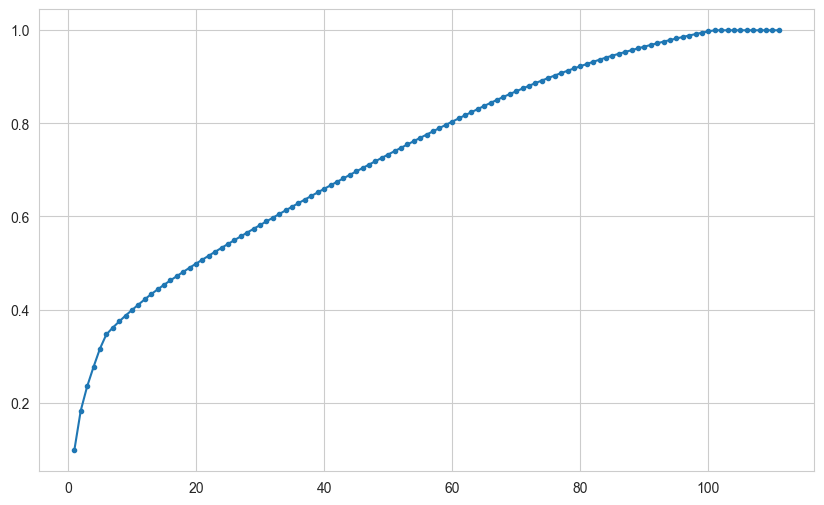

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(
    pca_results["n_components"],
    pca_results["cumulative_variance"],
    marker="o",
    markersize=3,
)

**Task** : Given your previous analysis, use PCA to reduce dimension.


In [60]:
num_componetns = 6

In [61]:
pca = PCA(n_components=num_componetns)
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=num_componetns, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score for k={num_componetns}: {silhouette_avg:.4f}")

Silhouette Score for k=6: 0.1309


### Number of clusters

Now that we have an _optimal_ feature matrix, we need to find the better number of cluster for the KMeans algorithm. The model, once trained, as an attribute `inertia` that can be tracked to get insights on how splitted the clusters are.

**Task** : Compute the inertia for several number of cluster, up to 30 for example.


In [64]:
num_clusters = list(range(2, 31))

silhouette_scores = []
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)
    print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")

Silhouette Score for k=2: 0.2112
Silhouette Score for k=3: 0.1718
Silhouette Score for k=4: 0.1465
Silhouette Score for k=5: 0.1388
Silhouette Score for k=6: 0.1309
Silhouette Score for k=7: 0.1283
Silhouette Score for k=8: 0.1227
Silhouette Score for k=9: 0.1256
Silhouette Score for k=10: 0.1234
Silhouette Score for k=11: 0.1202
Silhouette Score for k=12: 0.1207
Silhouette Score for k=13: 0.1200
Silhouette Score for k=14: 0.1181
Silhouette Score for k=15: 0.1149
Silhouette Score for k=16: 0.1137
Silhouette Score for k=17: 0.1137
Silhouette Score for k=18: 0.1142
Silhouette Score for k=19: 0.1155
Silhouette Score for k=20: 0.1140
Silhouette Score for k=21: 0.1138
Silhouette Score for k=22: 0.1119
Silhouette Score for k=23: 0.1116
Silhouette Score for k=24: 0.1141
Silhouette Score for k=25: 0.1140
Silhouette Score for k=26: 0.1132
Silhouette Score for k=27: 0.1139
Silhouette Score for k=28: 0.1121
Silhouette Score for k=29: 0.1127
Silhouette Score for k=30: 0.1129


**Task** : Display the informations of the previous cell into a self-explanatory plot. Use it to make a decision on the optimal number of cluster.


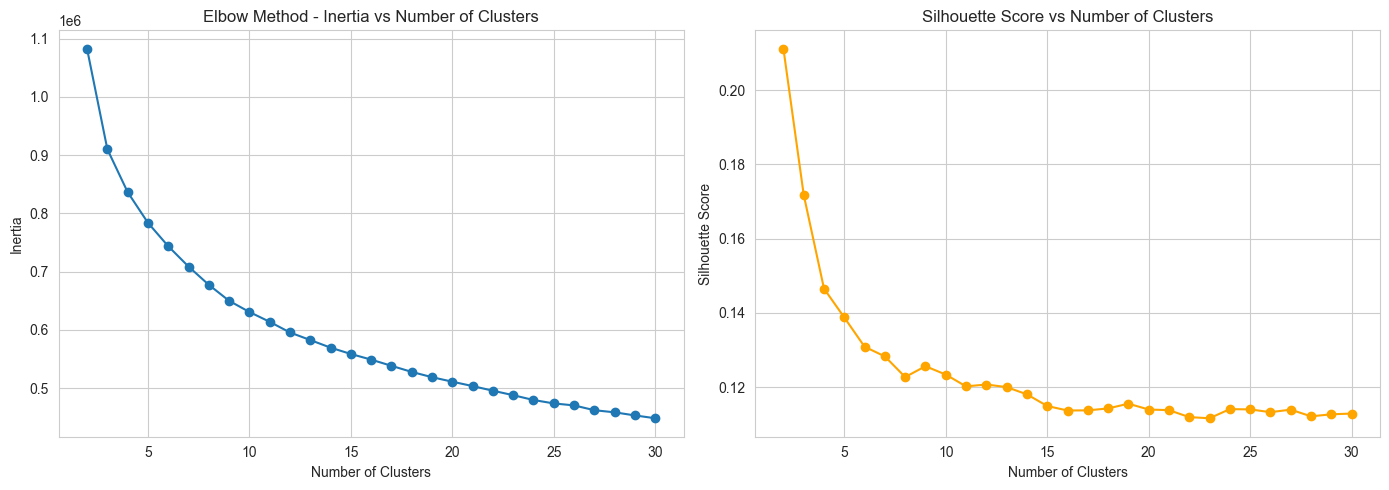

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(num_clusters, inertias, marker="o")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Elbow Method - Inertia vs Number of Clusters")

axes[1].plot(num_clusters, silhouette_scores, marker="o", color="orange")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score vs Number of Clusters")

plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

In [72]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

**Task** : Adapt the following cells (if needed) given your previous choice, and the choices above.

We are creating a dataframe with two columns :

- **ID** : the identifier of the person
- **prediction** : your prediction on if he is going to vote for your candidate or not (0 / 1)
  The dataframe must only contains the rows with no target known. The prediction will come from the average target in each cluster we build. We will predict 1 if the average is above 0.5, 0 instead.


In [73]:
study = df[["ID", "target"]]
study["Cluster"] = cluster_labels
clusters = study.groupby(by="Cluster", as_index=False).agg("mean")[
    ["Cluster", "target"]
]
clusters.columns = ["Cluster", "Average"]

study = study.merge(clusters, on="Cluster")
study = study.loc[study["target"].isna(),]
study["prediction"] = (study["Average"] > 0.5).astype(int)
answer = study[["ID", "prediction"]]
answer.head()

/var/folders/nd/jw9h_5215q3cx8t5kjj7fyg40000gn/T/ipykernel_24499/925570841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study["Cluster"] = cluster_labels


,ID,prediction
0,20160303022202,0
2,20160303052049,0
3,20160303052319,0
5,20160303055318,0
6,20160303063505,1


**Task** : save the dataframe _answer_ and submit your prediction on the [Kaggle competition](https://www.kaggle.com/t/4817e6d424c040a98571c0277e88b18a).


theo cheives 41%


In [74]:
answer.to_csv("submit.csv", index=False)